# Aula 13 - Self-Organizing Map (SOM)

## Instalação da biblioteca MiniSom

Veja a documentação e outros exemplos de uso/aplicação em: https://github.com/JustGlowing/minisom

In [1]:
!pip install minisom

In [4]:
# Imports pertinentes
import warnings
warnings.filterwarnings("ignore")

from minisom import MiniSom

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Clusterização

Aqui vamos usar um dataset padrão da Internet, que é baixado de uma URL. O cabeçalho do arquivo é `"area", "perimeter", "compactness", "length_kernel", "width_kernel", "asymetry_coefficient", "kernel_groove", "target"`, **nesta ordem**, separadas por tabulação (\t)

Para compor o dataframe final, usaremos apenas a 1ª e a 6ª coluna (índices 0 e 5 do parâmetro `usecols`).

In [5]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt",
            names=["area", "perimeter", "compactness", "length_kernel", "width_kernel", 
                   "asymetry_coefficient", "kernel_groove", "target"],
                  usecols=[0, 5],
                  sep="\t+", 
                  engine="python")

In [7]:
# Normalizar os dados
data = (df - np.mean(df, axis=0)) / np.std(df, axis=0)
data

,area,asymetry_coefficient
0,0.142098,-0.986152
1,0.011188,-1.788166
2,-0.192067,-0.667479
3,-0.347091,-0.960818
4,0.445257,-1.563495
...,...,...
205,-0.915515,-0.046135
206,-1.246235,0.416540
207,-0.567571,3.076588
208,-1.036090,-0.068135


In [8]:
# Pegando os dados em si como numpy array
data = data.values

In [14]:
# Inicialização e treinamento dos mapas
som_shape = (1, 3)
som = MiniSom(som_shape[0],  # Numero de linhas
              som_shape[1],  # Número de colunas
              data.shape[1], # Número de colunas nos dados
              learning_rate=0.5,
              sigma=0.5,
              random_seed=10,
              neighborhood_function="gaussian"
             )

som.train(data, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.846705446733947


**Neurônios vencedores**: para o caso da clusterização, cada neurônio do SOM é um centroid de um cluster. O neurônio vencedor é o cluster que foi ativado para determinado dado (ou seja, indica a qual cluster o dado pertence). 

Sempre obtemos o neurônio vencedor de cada dado, por isso iteremos para cada dado `x` dos dados, e isso alimenta função `som.winner(x)`.

In [18]:
# Quais são os neurônios vencedores? 
winner_neurons = np.array([som.winner(x) for x in data]).T

In [21]:
# Quais são os índices dos clusteres? 
cluster_index = np.ravel_multi_index(winner_neurons, som_shape)

**Posição dos centroids**: vale lembrar que no SOM, o peso é a representação do neurônio, logo, no caso da clusterização, cada peso representa a posição do neurônio no espaço. Assim, os pesos indicam onde cada neurônio (que é um centroid!) está no espaço! 

Pegamos o valor dos pesos por meio da função `get_weights()`.

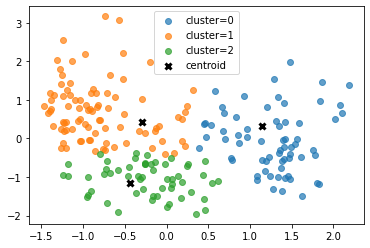

In [31]:
# Plotar o cluster das 2 primeiras dimensões
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0], # eixo X
                data[cluster_index == c, 1], # eixo Y
                label="cluster="+str(c), alpha=0.7
               )
    
# Plotar os centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:,0], centroid[:,1], marker="x",
               label="centroid", color="k", linewidths=3)
    
plt.legend()

# Quantificação de cores em imagens

In [86]:
# Carregar a imagem
img = plt.imread("tree.jpg")

In [87]:
# Remodelar a matriz de pixels
pixels = np.reshape(img,
                   (img.shape[0]*img.shape[1], 3)) / 255.

In [98]:
# Inicializar o SOM
som2 = MiniSom(2, 3, # Quero um SOM com 2 linhas e 3 colunas, ou seja, 2x3=6 cores
               3,    # Número de canais de entrada 
              learning_rate=0.02, sigma=0.5, 
              neighborhood_function="bubble")

# Inicializa os pesos do SOM escolhendo amostras aleatórias pertencentes aos dados de entrada.
som2.random_weights_init(pixels)

# Salva os pesos inicializados (vamos usar adiante)
starting_weights = som2.get_weights().copy()

In [99]:
# Treina o SOM
som2.train(pixels, 10000, random_order=True, verbose=True)

 [   296 / 10000 ]   3% - 0:00:06 left 

 [   608 / 10000 ]   6% - 0:00:06 left 

 [   882 / 10000 ]   9% - 0:00:06 left 

 [  1246 / 10000 ]  12% - 0:00:05 left 

 [  1491 / 10000 ]  15% - 0:00:05 left 

 [  1726 / 10000 ]  17% - 0:00:05 left 

 [  1994 / 10000 ]  20% - 0:00:05 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.12884752152341447


In [100]:
# Obter o mapeamento das cores resultantes 
qnt = som2.quantization(pixels)

In [101]:
# Construir uma imagem nova a partir das cores resultantes 
imagemFinal = np.zeros(img.shape)
for i, q in enumerate(qnt):
    imagemFinal[np.unravel_index(i, 
                                dims=(img.shape[0], img.shape[1]))] = q

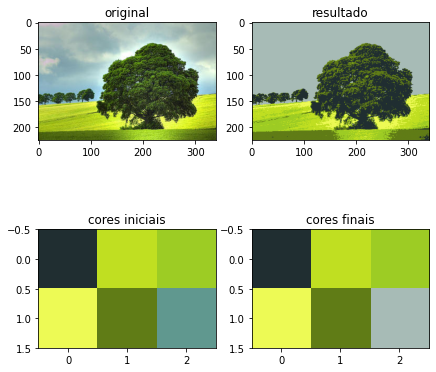

In [102]:
# Mostrar os resultados
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(img)
ax[0, 0].set_title("original")

ax[0, 1].imshow(imagemFinal)
ax[0, 1].set_title("resultado")

ax[1, 0].imshow(starting_weights)
ax[1, 0].set_title("cores iniciais")

ax[1, 1].imshow(som2.get_weights()) # As cores finais são os pesos aprendidos ao final do processo de treinamento! 
ax[1, 1].set_title("cores finais")

plt.show()